#### Competition: https://www.kaggle.com/c/demand-forecasting-kernels-only

## LSTM model definition and training

In [ ]:
# The code was removed by Watson Studio for sharing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import path
import skimage.measure

import keras
from keras.models import Model
from keras.layers import Dense, Concatenate
from keras.layers import LSTM, Input
from keras.layers.normalization import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
try:
    _file = project.get_file('adsc.etl.csv.1.csv')
except:
    _file = path.Path('adsc.etl.csv.1.csv')

In [3]:
dataset = pd.read_csv(_file).set_index('date')
dataset.head()

,store,item,sales,year,month,year-month,day-of-month,day-of-week,day-of-year
date,,,,,,,,,
2013-01-01,1,1,13,2013,1,2013-01,1,1,1
2013-01-01,7,12,26,2013,1,2013-01,1,1,1
2013-01-01,7,46,27,2013,1,2013-01,1,1,1
2013-01-01,8,12,54,2013,1,2013-01,1,1,1
2013-01-01,9,12,35,2013,1,2013-01,1,1,1


In [4]:
look_back = 20
predict_forward = 120

col = [i for i in dataset.columns if i not in ['year-month']]

features = [0, 1, 2, 3, 4, 5, 6, 7]
stores = [1]
items = [1]

def create_dataset(normal_set, scaler, predict_forward):
    dataX1, dataY = [], []
    for store in stores:
        for item in items:
            item_set = normal_set[(normal_set.store == store) & (normal_set.item == item)]
            for idx in range(0, len(item_set) - look_back - predict_forward):
                # dataX.append(train_set.iloc[idx-look_back:idx, 0:6].values)
                split_point = idx+look_back
                x_set = item_set.iloc[idx:split_point, :]
                y_set = item_set.iloc[split_point:split_point+predict_forward, :]
                x1 = scaler.transform(x_set.iloc[:, features].values)
                dataX1.append(x1)
                dataY.append(y_set.iloc[:, [2, 6]].values)
    return np.array(dataX1), np.array(dataY)# .reshape(-1, predict_forward)

num_features = len(features)

scaler = MinMaxScaler()
scaler.fit(dataset[col])


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X1, Y = create_dataset(
    dataset[col].sort_values(by=['store', 'item']), scaler, predict_forward)

display(X1.shape)
display(Y.shape)

(1686, 20, 8)

(1686, 120, 2)

In [5]:
train_X1, test_X1, train_Y, test_Y = train_test_split(X1, Y, test_size=0.1, random_state=42)

display(train_X1.shape)
display(test_X1.shape)
display(train_Y.shape)
display(test_Y.shape)

(1517, 20, 8)

(169, 20, 8)

(1517, 120, 2)

(169, 120, 2)

In [6]:
train_X1_reshaped = train_X1.reshape((-1, look_back, num_features))
test_X1_reshaped = test_X1.reshape((-1, look_back, num_features))

display(train_X1_reshaped.shape)

(1517, 20, 8)

### Model definiton

In [105]:
batch_size = 128
import tensorflow as tf

input_layer1 = Input(batch_shape=(batch_size, look_back, num_features))
lstm02 = LSTM(120, stateful=False, return_sequences=True, recurrent_activation='tanh')(input_layer1)
conv1 = keras.layers.Conv1D(kernel_size=7, filters=60, padding='valid')(lstm02)
pool1 = keras.layers.MaxPooling1D(7)(conv1)
act2 = keras.layers.Activation('relu')(pool1)
norm2 = BatchNormalization(
    epsilon=0.001, axis=-1, momentum=0.99, weights=None,
    beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(act2)
dense = Dense(60, kernel_regularizer=keras.regularizers.l2(0.01))(norm2)
flat = keras.layers.Flatten()(dense)
out = Dense(predict_forward)(flat)
model = Model(inputs=input_layer1, outputs=out)
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)
model.compile(loss='mse', optimizer=sgd, metrics=["mape"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (128, 20, 8)              0         
_________________________________________________________________
lstm_47 (LSTM)               (128, 20, 120)            61920     
_________________________________________________________________
conv1d_58 (Conv1D)           (128, 14, 60)             50460     
_________________________________________________________________
max_pooling1d_58 (MaxPooling (128, 2, 60)              0         
_________________________________________________________________
activation_45 (Activation)   (128, 2, 60)              0         
_________________________________________________________________
batch_normalization_45 (Batc (128, 2, 60)              240       
_________________________________________________________________
dense_40 (Dense)             (128, 2, 60)              3660      
__________

### Model training

In [106]:
epochs = 250
idx = int(len(train_X1_reshaped)/batch_size) * batch_size
hist = model.fit(
    train_X1_reshaped[:idx],
    train_Y[:idx, :, 0], # ['sales'].values.reshape(len(train_Y['sales']), 1)[:-1],
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    shuffle=True)

Epoch 1/250
1408/1408 [==============================] - 4s 3ms/step - loss: 396.6352 - mean_absolute_percentage_error: 91.4307
Epoch 2/250
1408/1408 [==============================] - 1s 813us/step - loss: 54.5900 - mean_absolute_percentage_error: 34.7641
Epoch 3/250
1408/1408 [==============================] - 1s 894us/step - loss: 38.5909 - mean_absolute_percentage_error: 28.8111
Epoch 4/250
1408/1408 [==============================] - 1s 948us/step - loss: 37.8155 - mean_absolute_percentage_error: 28.2656
Epoch 5/250
1408/1408 [==============================] - 1s 864us/step - loss: 34.1581 - mean_absolute_percentage_error: 27.1082
Epoch 6/250
1408/1408 [==============================] - 1s 785us/step - loss: 32.3210 - mean_absolute_percentage_error: 26.0752
Epoch 7/250
1408/1408 [==============================] - 1s 831us/step - loss: 32.0455 - mean_absolute_percentage_error: 25.7689
Epoch 8/250
1408/1408 [==============================] - 1s 852us/step - loss: 32.0973 - mean_abso

### Model evaluation

In [107]:
# expected = test_Y # ['sales'].values.reshape(len(test_Y['sales']), 1)
test_idx = int(len(test_X1_reshaped)/batch_size) * batch_size
model.evaluate(test_X1_reshaped[:test_idx], test_Y[:test_idx, :, 0], batch_size=batch_size)

128/128 [==============================] - 1s 8ms/step


[19.332260131835938, 18.91453742980957]

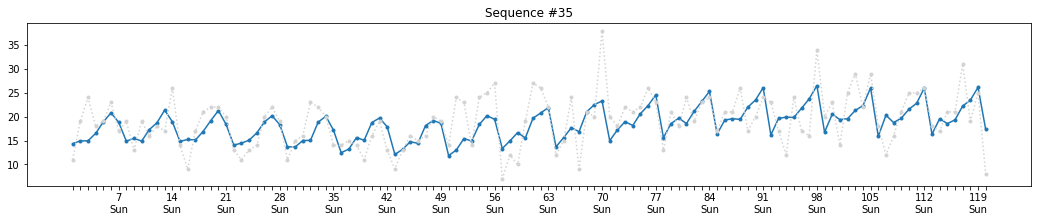

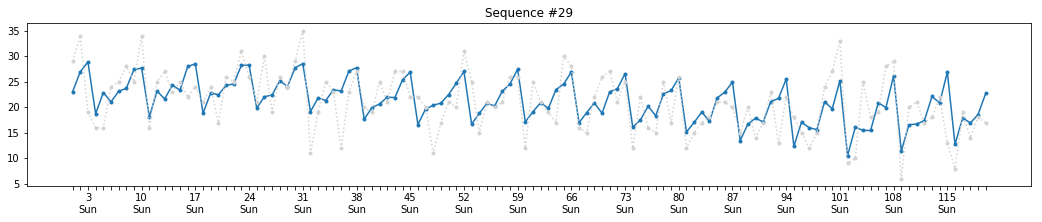

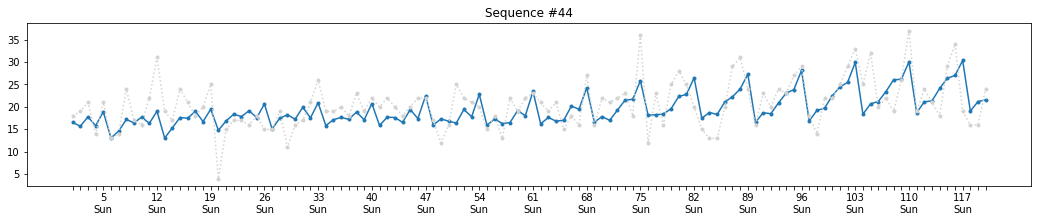

In [108]:
Yhat = model.predict(test_X1_reshaped[:test_idx], batch_size=batch_size)
# display(predicted.T[0], expected.T[0])
# inv_yhat = concatenate((predicted, test_X[:, 1:]), axis=1)
selection = np.random.randint(0, test_Y.shape[1], 3)

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for it in selection:
    plt.figure(figsize=(18, 3))
    plt.title("Sequence #%s" % it)
    plt.plot(Yhat[it], marker='.')
    labels = [''] * predict_forward
    for i, d in enumerate(test_Y[it, :, 1]):
        if d == 6:
            labels[i] = "%s\n%s" % (i+1, days[d])
    plt.xticks(range(len(test_Y[it, :, 0])), labels)
    plt.plot(test_Y[it, :, 0],  marker='.', linestyle=':', color='lightgray')

In [110]:
model.save('model.h5')